# <center> Forecasting City Finances - Preprocessing</center>


## Import Packages
The needed packages for treating the data are imported below:

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

## Load the data
We now load the data that we cleaned in the data wrangling step.

In [3]:
pwd_data = '/Users/Varishth/Desktop/Springboard_Projects/capstone_two/data/timeseries_data.csv'
df_TS = pd.read_csv(pwd_data)
df_TS.head()

,year,state_city,rev_total
0,1977,AK: Anchorage,5342.24
1,1978,AK: Anchorage,5948.99
2,1979,AK: Anchorage,6158.68
3,1980,AK: Anchorage,5654.93
4,1981,AK: Anchorage,6192.83


## Slight field adjusments
We have two slight adjusments to make: 1) make the year the index of the dataframe, and 2) separate city and states

In [4]:
# make the year column as the index
df_TS.index = pd.to_datetime(df_TS.year, format='%Y')
df_TS.drop("year",axis=1, inplace=True)

df_TS.head()

,state_city,rev_total
year,,
1977-01-01,AK: Anchorage,5342.24
1978-01-01,AK: Anchorage,5948.99
1979-01-01,AK: Anchorage,6158.68
1980-01-01,AK: Anchorage,5654.93
1981-01-01,AK: Anchorage,6192.83


In [5]:
# create a new field to store the state values
df_TS['state'] = df_TS.state_city.str.split(pat=": ", ).str[0]

# remove the state values from the city_name field
df_TS.state_city = df_TS.state_city.str.split(pat=": ", ).str[1]

In [6]:
# re-order columns
df_TS = df_TS[["state", "state_city", "rev_total"]]
df_TS.columns = ["state", "city", "rev_total"]


df_TS.head()

,state,city,rev_total
year,,,
1977-01-01,AK,Anchorage,5342.24
1978-01-01,AK,Anchorage,5948.99
1979-01-01,AK,Anchorage,6158.68
1980-01-01,AK,Anchorage,5654.93
1981-01-01,AK,Anchorage,6192.83


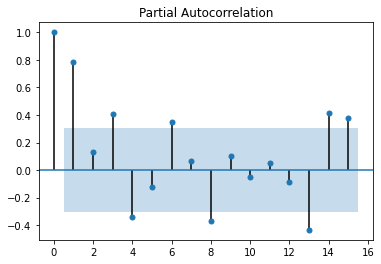

In [7]:
ts_eg = df_TS.loc[df_TS["city"]=="New York"]["rev_total"]
ts_eg.index = pd.DatetimeIndex(ts_eg.index.values,freq=ts_eg.index.inferred_freq)
plot_pacf(ts_eg, lags=15);

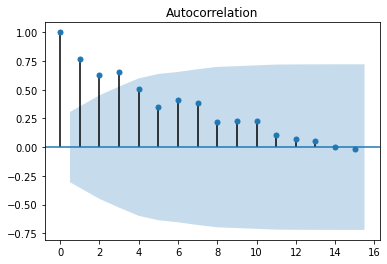

In [8]:
plot_acf(ts_eg, lags=15);

In [9]:
ts_eg.index = pd.DatetimeIndex(ts_eg.index.values,freq=ts_eg.index.inferred_freq)
ts_eg.index

DatetimeIndex(['1977-01-01', '1978-01-01', '1979-01-01', '1980-01-01',
               '1981-01-01', '1982-01-01', '1983-01-01', '1984-01-01',
               '1985-01-01', '1986-01-01', '1987-01-01', '1988-01-01',
               '1989-01-01', '1990-01-01', '1991-01-01', '1992-01-01',
               '1993-01-01', '1994-01-01', '1995-01-01', '1996-01-01',
               '1997-01-01', '1998-01-01', '1999-01-01', '2000-01-01',
               '2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2017-01-01'],
              dtype='datetime64[ns]', freq='AS-JAN')

## Test Stationarity

In [10]:
# check_adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
    
# check_mean_std
def check_mean_std(ts):
    #Rolling statistics
    rolmean = ts.rolling(3).mean()
    rolstd = ts.rolling(3).std()
    plt.figure(figsize=(22,10))   
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

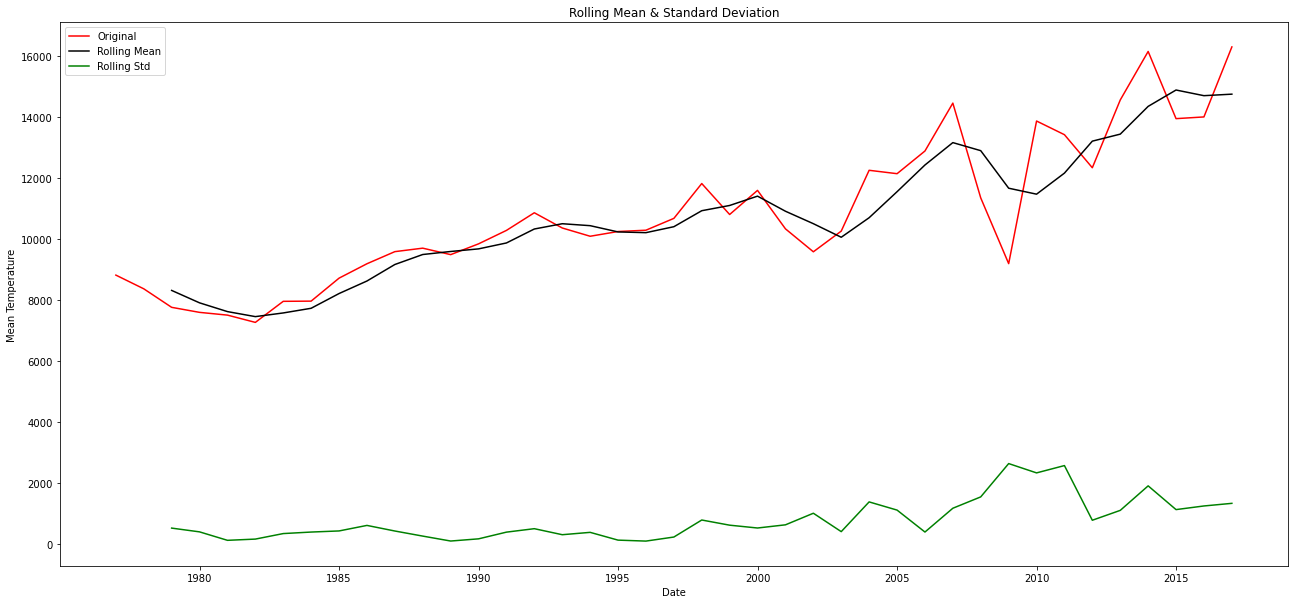

Test statistic:  0.6285611194411457
p-value:  0.9882988584167703
Critical Values: {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}


In [11]:
# check stationary: mean, variance(std)and adfuller test
trial_ts = df_TS.loc[df_TS["city"]=="New York"]["rev_total"]
trial_ts.index = pd.DatetimeIndex(trial_ts.index.values,freq=trial_ts.index.inferred_freq)
check_mean_std(trial_ts)
check_adfuller(trial_ts.values)

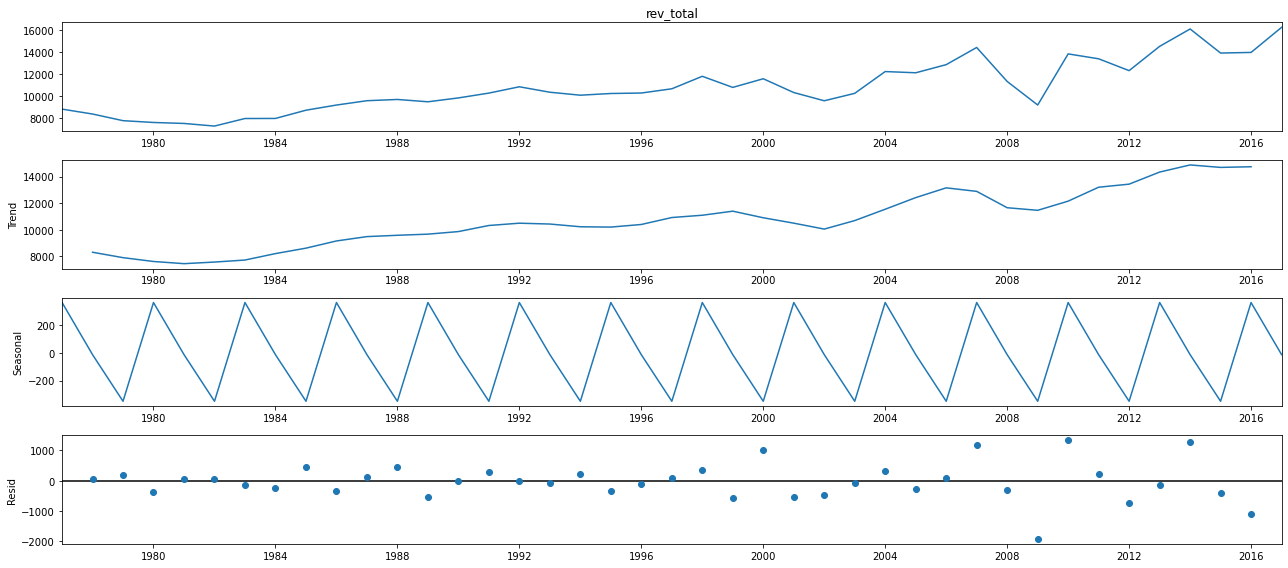

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(trial_ts, model='additive', period=3)
fig = decomposition.plot()
plt.show()

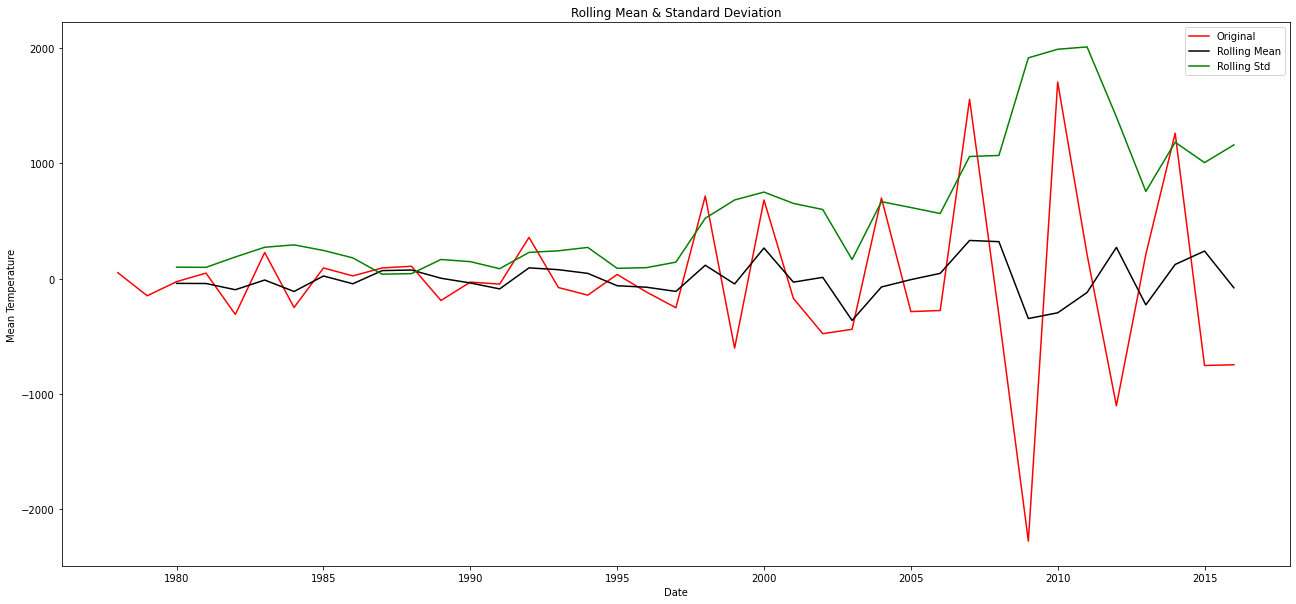

Test statistic:  -2.6548749008618957
p-value:  0.08217762749885704
Critical Values: {'1%': -3.6889256286443146, '5%': -2.9719894897959187, '10%': -2.6252957653061224}


In [13]:
ts_detrended = trial_ts.values - decomposition.trend
ts_detrended.dropna(inplace=True)

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_detrended)
check_adfuller(ts_detrended.values)

## Make timeseries stationary

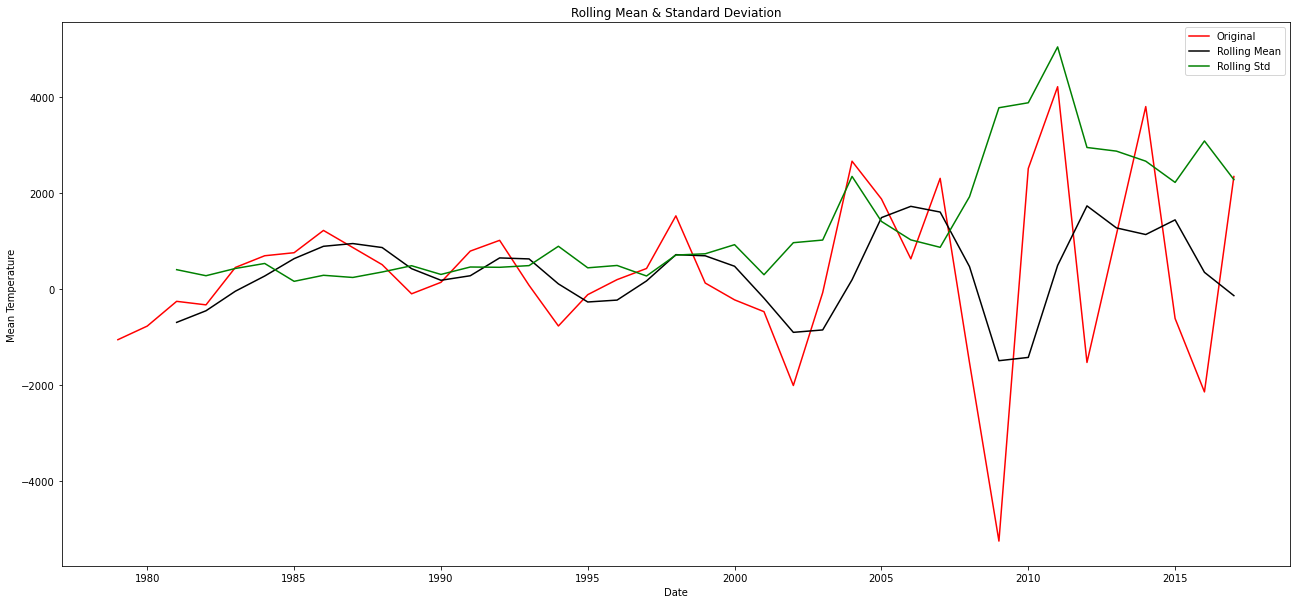

Test statistic:  -6.535369215756032
p-value:  9.63865141240772e-09
Critical Values: {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}


In [58]:
# differencing method
ts_diff = trial_ts - trial_ts.shift(2)
ts_diff.dropna(inplace=True)
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff.values)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

<Figure size 1080x720 with 0 Axes>

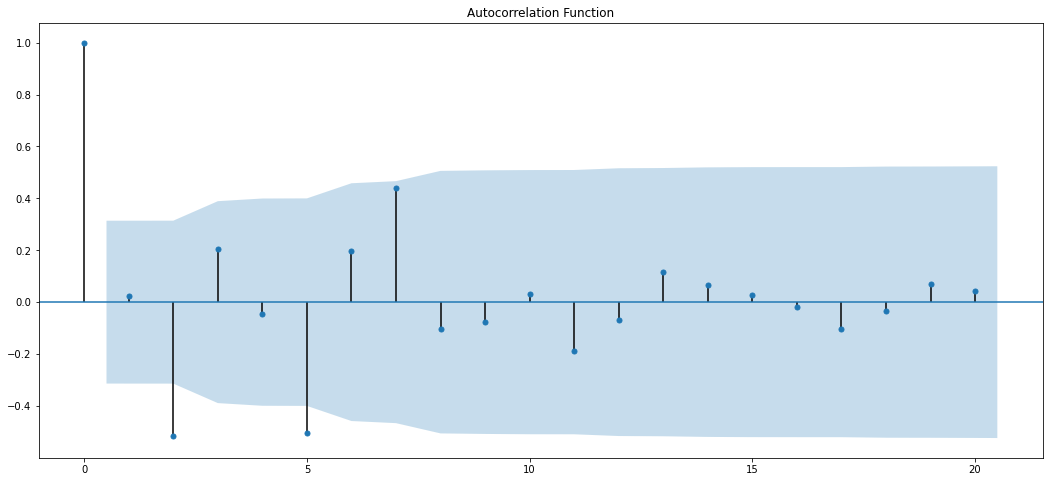

<Figure size 1080x720 with 0 Axes>

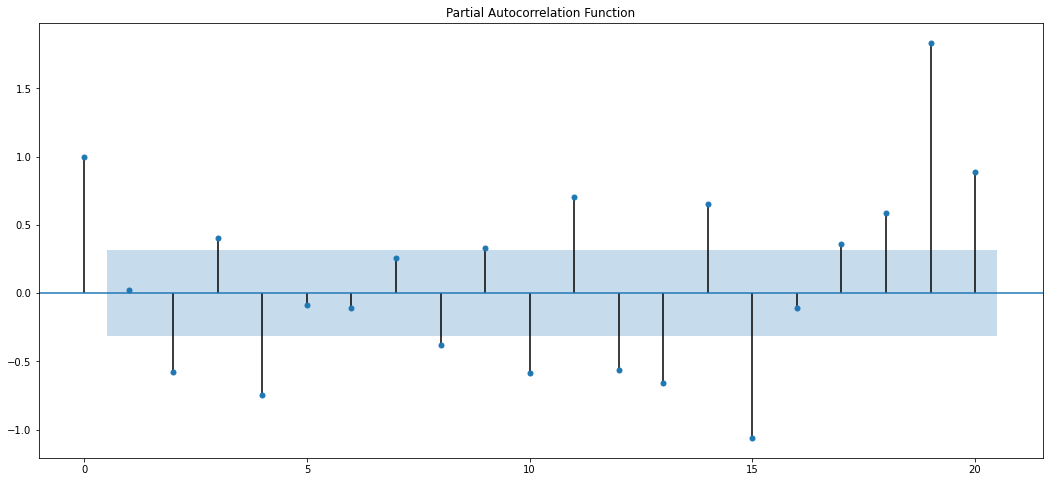

In [59]:
# ACF
plt.figure(figsize=(15,10))
plot_acf(ts_diff, lags=20)
plt.title('Autocorrelation Function')

# PACF
plt.figure(figsize=(15,10))
plot_pacf(ts_diff, lags=20,method='ols')
plt.title('Partial Autocorrelation Function')

# Modeling attempts


## ARIMA model

Mean square error:  1259.5114030399661
Mean absolute percent error:  7.86%


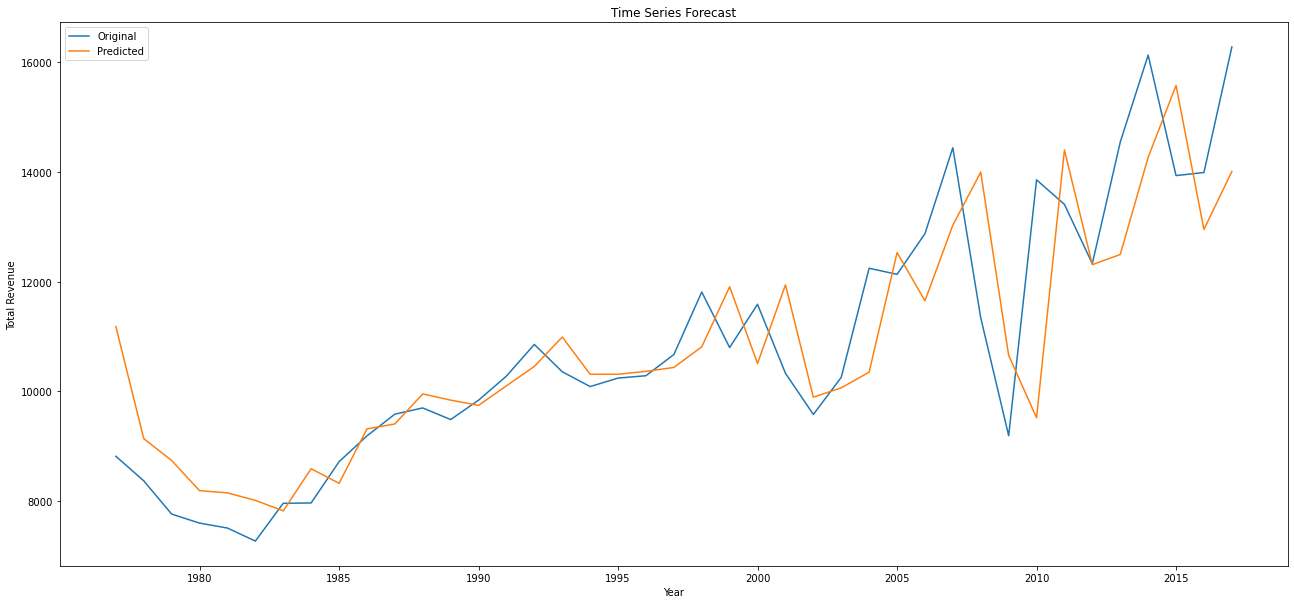

In [61]:
# fit model
arima101 = ARIMA(trial_ts, order=(2,0,1)) # (ARMA) = (2,0,2)
arima101_fit = arima101.fit()

# predict
arima101_forecast = arima101_fit.predict()

# quantify error
mserror = mean_squared_error(trial_ts[1:], arima101_forecast[1:])
print("Mean square error: ", np.sqrt(mserror))
pct_error = np.abs(trial_ts[1:] - arima101_forecast[1:])/trial_ts[1:]
#print("Mean square error: ", "{:.2%}".format(pct_error))
print("Mean absolute percent error: ", "{:.2%}".format(np.mean(pct_error)))


# visualization
plt.figure(figsize=(22,10))
plt.plot(trial_ts,label = "Original")
plt.plot(arima101_forecast,label = "Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Year")
plt.ylabel("Total Revenue")
plt.legend()
plt.show()

## SARIMAX Model

In [ ]:
# Creating a list to find hyperparameters for SARIMAX model
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
# Finding hyperparameters for SARIMAX model that give the lowest AIC
min_aic = 10000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trial_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_aic:
                min_aic = results.aic
                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
sarimax = sm.tsa.statespace.SARIMAX(trial_ts,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False) #ARIMA(0, 1, 1)x(0, 1, 1, 12)
sarimax_fit = sarimax.fit()
sarimax_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
# predict
sarimax_forecast = sarimax_fit.predict()

# quantify error
mserror = mean_squared_error(trial_ts[1:], sarimax_forecast[1:])
print("Mean square error: ", mserror)
pct_error = np.abs(trial_ts[1:] - sarimax_forecast[1:])/trial_ts[1:]
#print("Mean square error: ", "{:.2%}".format(pct_error))
print("Mean absolute percent error: ", "{:.2%}".format(np.mean(pct_error)))


# visualization
plt.figure(figsize=(22,10))
plt.plot(trial_ts[1:],label = "Original")
plt.plot(sarimax_forecast[1:],label = "Predicted")
plt.title("Time Series Forecast")
plt.xlabel("Year")
plt.ylabel("Total Revenue")
plt.legend()
plt.show()